#### Environment: pt_fpad  
Python: 3.10.4     
Pytorch: 2.1.1+cu118

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms, models
import torch.optim as optim
import os
import random
import cv2
import numpy as np
import glob
from PIL import Image


from deformable_conv import DeformableConv2d

In [2]:
class SiWMv2Dataset(Dataset):
    def __init__(self, live_path, spoof_path, live_ref, spoof_ref):
        self.transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),transforms.Normalize(mean=[0.5], std=[0.5])])
        self.live_path = live_path
        self.spoof_path = spoof_path
        self.images = []
        self.labels = []
        self.real = 0
        self.attack = 1
        
        with open(live_ref, 'r') as f:
            content = f.read()
        live_dirs = content.split('\n')
        
        with open(spoof_ref, 'r') as f:
            content = f.read()
        spoof_dirs = content.split('\n')
        
        for ldir in live_dirs:
            if ldir != '' and ldir != ' ':
                ldir_path = os.path.join(self.live_path, ldir)
                if os.path.exists(ldir_path):
                    lcontent = os.listdir(ldir_path)
                    lcontent = [os.path.join(ldir_path, f) for f in lcontent if f.endswith('png')]
                    self.images.extend(lcontent)
                    self.labels.extend([self.real] * len(lcontent))
                else:
                    print(ldir_path)
        
        for sdir in spoof_dirs:
            if sdir != '' and sdir != ' ':
                sdir_path = os.path.join(self.spoof_path, sdir)
                scontent = os.listdir(sdir_path)
                scontent = [os.path.join(sdir_path, f) for f in scontent if f.endswith('png')]
                self.images.extend(scontent)
                self.labels.extend([self.attack] * len(scontent))
        
        self.data_len = len(self.images)
        

    def __len__(self): # returns the total number of samples in the dataset
        return self.data_len

    def __getitem__(self, idx): # loads and returns a sample from the dataset at the given index
        imgpath = self.images[idx]
        img = Image.open(imgpath).convert('RGB')
        img = self.transform(img)
        return img, self.labels[idx]

In [3]:
device = torch.device(0)

In [4]:
class_label_real = 0
class_label_attack = 1

In [5]:
real_dir = r'/data/ssd2/shakeel-workspace/DOWNLOAD/SiW-Mv2_preprocessed/Live/'
spoof_dir = r'/data/ssd2/shakeel-workspace/DOWNLOAD/SiW-Mv2_preprocessed/Spoof_root/'

# Protocol 1

train_spoof_ref = r'/data/ssd2/shakeel-workspace/DOWNLOAD/SiW-Mv2_preprocessed/trainlist_all.txt'
train_live_ref = r'/data/ssd2/shakeel-workspace/DOWNLOAD/SiW-Mv2_preprocessed/trainlist_live.txt'
test_spoof_ref = r'/data/ssd2/shakeel-workspace/DOWNLOAD/SiW-Mv2_preprocessed/testlist_all.txt'
test_live_ref =r'/data/ssd2/shakeel-workspace/DOWNLOAD/SiW-Mv2_preprocessed/testlist_live.txt'

# train_spoof_ref = r'protocol_1/train_spoof.txt'
# train_live_ref = r'protocol_1/train_live.txt'
# val_spoof_ref = r'protocol_1/val_spoof.txt'
# val_live_ref = r'protocol_1/val_live.txt'
# test_spoof_ref = r'/data/ssd2/shakeel-workspace/DOWNLOAD/SiW-Mv2_preprocessed/testlist_all.txt'
# test_live_ref =r'/data/ssd2/shakeel-workspace/DOWNLOAD/SiW-Mv2_preprocessed/testlist_live.txt'

In [6]:
train_dataset = SiWMv2Dataset(real_dir, spoof_dir, train_live_ref, train_spoof_ref)
# val_dataset = SiWMv2Dataset(real_dir, spoof_dir, val_live_ref, val_spoof_ref)
test_dataset = SiWMv2Dataset(real_dir, spoof_dir, test_live_ref, test_spoof_ref)

train_loader = DataLoader(train_dataset, batch_size  = 64, shuffle = True, pin_memory = True, num_workers = 8)
# val_loader = DataLoader(val_dataset, batch_size  = 64, shuffle = True, pin_memory = True, num_workers = 8)
test_loader = DataLoader(test_dataset, batch_size  = 64, shuffle = True, pin_memory = True, num_workers = 8)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
# print(f"Training set size: {len(val_dataset)}")
print(f"Validation set size: {len(test_dataset)}")

/data/ssd2/shakeel-workspace/DOWNLOAD/SiW-Mv2_preprocessed/Live/Live_892
/data/ssd2/shakeel-workspace/DOWNLOAD/SiW-Mv2_preprocessed/Live/Live_894
/data/ssd2/shakeel-workspace/DOWNLOAD/SiW-Mv2_preprocessed/Live/Live_895
/data/ssd2/shakeel-workspace/DOWNLOAD/SiW-Mv2_preprocessed/Live/Live_897
/data/ssd2/shakeel-workspace/DOWNLOAD/SiW-Mv2_preprocessed/Live/Live_898
/data/ssd2/shakeel-workspace/DOWNLOAD/SiW-Mv2_preprocessed/Live/Live_901
/data/ssd2/shakeel-workspace/DOWNLOAD/SiW-Mv2_preprocessed/Live/Live_902
/data/ssd2/shakeel-workspace/DOWNLOAD/SiW-Mv2_preprocessed/Live/Live_893
/data/ssd2/shakeel-workspace/DOWNLOAD/SiW-Mv2_preprocessed/Live/Live_896
/data/ssd2/shakeel-workspace/DOWNLOAD/SiW-Mv2_preprocessed/Live/Live_899
/data/ssd2/shakeel-workspace/DOWNLOAD/SiW-Mv2_preprocessed/Live/Live_900
Training set size: 339576
Validation set size: 110019


In [7]:
# Load pre-trained ResNet18
# model = models.resnet18(pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)

# Load pre-trained MobileNetV2
model = models.mobilenet_v2(pretrained=True)
# model.features[0] = DeformableConv2d(3, 32, 3, 2, 1)
model.features[-1] = nn.Sequential(
    DeformableConv2d(320, 1280, 3, 2),
    nn.BatchNorm2d(1280),
    nn.ReLU6()
)
model.classifier[1] = nn.Linear(in_features=1280, out_features=2) #default in_features =1280, out_features = 1000

best_model_path = r'checkpoint_protocol_1_wo_val/best_142_4.0373697962606216e-07.pth'
state_dict = torch.load(best_model_path,  map_location=device)
model.load_state_dict(state_dict, strict = True)
print(model)

/home/eslab/anaconda3/envs/facerec_new/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/eslab/anaconda3/envs/facerec_new/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
best_model_path = None

In [10]:
epochs = 200

model.to(device)

train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

# Set up early stopping parameters
patience = 30  # Number of epochs with no improvement after which training will be stopped
best_loss = float('inf') #set to positive infinity to ensure that the first validation loss encountered will always be considered an improvement
counter = 0  # Counter to keep track of consecutive epochs with no improvement

#Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    train_correct_predictions = 0
    total_train_samples = 0

    for train_images, train_labels in train_loader:
        train_images, train_labels = train_images.to(device), train_labels.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        train_outputs = model(train_images)
        # Find the Loss
        train_loss = criterion(train_outputs, train_labels)
        # Calculate gradients
        train_loss.backward()
        # Update Weights
        optimizer.step()

        # accumulate the training loss
        running_loss += train_loss.item()

        # calculate training accuracy
        _, train_predicted = torch.max(train_outputs, 1) # _ contain max value, train_predicted contain the indices where maximum value occured
        train_correct_predictions += (train_predicted == train_labels).sum().item() 
        total_train_samples += train_labels.size(0)
            
    train_total_loss = running_loss / len(train_loader)
    train_accuracy = train_correct_predictions / total_train_samples * 100
    train_losses.append(train_total_loss)
    train_accuracies.append(train_accuracy)

    val_running_loss = 0.0
    val_correct_prediction = 0
    total_val_samples = 0

    # #Validation
    # model.eval()
    # with torch.no_grad():
    #     for val_images, val_labels in val_loader:
    #         val_images, val_labels = val_images.to(device), val_labels.to(device)
    #         val_op = model(val_images)
    #         val_loss = criterion(val_op, val_labels)
    #         val_running_loss += val_loss.item()

    #         _, val_predicted = torch.max(val_op, 1)
    #         val_correct_prediction += (val_predicted == val_labels).sum().item()
    #         total_val_samples += val_labels.size(0)
        
    #     val_total_loss = val_running_loss / len(val_loader)
    #     val_accuracy = val_correct_prediction / total_val_samples * 100
    #     val_losses.append(val_total_loss)
    #     val_accuracies.append(val_accuracy)

    # # Check if validation loss has improved
    # if val_total_loss < best_loss:
    #     best_loss = val_total_loss
    #     counter = 0
    #     best_model_path = r'checkpoint_protocol_1/best_{}_{}.pth'.format(epoch+ 1, best_loss)
    #     # Save the model if needed
    #     torch.save(model.state_dict(), best_model_path)

    # else:
    #     counter += 1

    #     # Check if training should be stopped
    #     if counter >= patience:
    #         print(f'Early stopping at epoch {epoch}')
    #         break

    best_model_path = r'checkpoint_protocol_1_wo_val_cont/best_{}_{}.pth'.format(epoch+ 1, train_total_loss)
    # Save the model if needed
    torch.save(model.state_dict(), best_model_path)
    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {train_total_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')

Epoch 1/200, Training Loss: 0.0010, Training Accuracy: 99.99%
Epoch 2/200, Training Loss: 0.0005, Training Accuracy: 99.99%
Epoch 3/200, Training Loss: 0.0007, Training Accuracy: 99.99%
Epoch 4/200, Training Loss: 0.0006, Training Accuracy: 99.99%
Epoch 5/200, Training Loss: 0.0007, Training Accuracy: 99.99%
Epoch 6/200, Training Loss: 0.0003, Training Accuracy: 99.99%
Epoch 7/200, Training Loss: 0.0005, Training Accuracy: 99.99%
Epoch 8/200, Training Loss: 0.0005, Training Accuracy: 99.99%
Epoch 9/200, Training Loss: 0.0003, Training Accuracy: 99.99%
Epoch 10/200, Training Loss: 0.0003, Training Accuracy: 99.99%
Epoch 11/200, Training Loss: 0.0002, Training Accuracy: 99.99%
Epoch 12/200, Training Loss: 0.0005, Training Accuracy: 99.98%
Epoch 13/200, Training Loss: 0.0004, Training Accuracy: 99.99%
Epoch 14/200, Training Loss: 0.0006, Training Accuracy: 99.99%
Epoch 15/200, Training Loss: 0.0004, Training Accuracy: 99.99%
Epoch 16/200, Training Loss: 0.0006, Training Accuracy: 99.99%
E

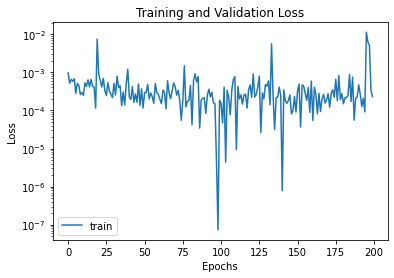

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Training and Validation Loss")
plt.plot(train_losses,label="train")
# plt.plot(val_losses,label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale('log')
plt.legend()
plt.show()

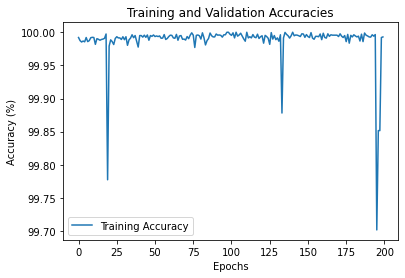

In [12]:
plt.figure()
plt.title("Training and Validation Accuracies")
plt.plot(train_accuracies,label="Training Accuracy")
# plt.plot(val_accuracies,label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [13]:
state_dict = torch.load(best_model_path,  map_location=device)
model.load_state_dict(state_dict, strict = True)

<All keys matched successfully>

In [14]:
# Evaluate on the test set
test_correct = 0
test_total = 0

model.eval()
with torch.no_grad():
    
    test_cat_labels = torch.empty(0, dtype=torch.int64, device=device)
    test_predicted_cat_labels = torch.empty(0, dtype=torch.int64, device=device)

    for test_images, test_labels in test_loader:
        test_images, test_labels = test_images.to(device), test_labels.to(device)
        test_model_op = model(test_images)
        _, test_predicted = torch.max(test_model_op, 1)
        test_correct += (test_predicted == test_labels).sum().item() 
        test_total += test_labels.size(0)

        test_cat_labels = torch.cat((test_cat_labels, test_labels))
        test_predicted_cat_labels = torch.cat((test_predicted_cat_labels, test_predicted))

    test_accuracy = test_correct / test_total * 100  
    print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 93.85%


In [15]:
test_cat_labels_cpu = test_cat_labels.cpu()
test_predicted_cat_labels_cpu = test_predicted_cat_labels.cpu()

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score

In [17]:
tn, fp, fn, tp = confusion_matrix(test_cat_labels_cpu, test_predicted_cat_labels_cpu).ravel()

print(f'TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')

acc_score = accuracy_score(test_cat_labels_cpu, test_predicted_cat_labels_cpu)
prec_score = precision_score(test_cat_labels_cpu, test_predicted_cat_labels_cpu)
recall = recall_score(test_cat_labels_cpu, test_predicted_cat_labels_cpu)

Y_I_val =(tp/(tp+fn)) + (tn/(tn+fp)) - 1
sensitivity_val = tp / (tp + fn)
specificity_val = tn / (tn + fp)
f1score_val = 2 * tp / (2 * tp + fp + fn)
FAR = fp/(fp + tn)
FRR = fn/(fn + tp)
HTER_val = (FAR + FRR)/2
EER = (fp+fn)/(tn+fp+fn+tp)
val_bacc = balanced_accuracy_score(test_cat_labels_cpu, test_predicted_cat_labels_cpu)


print('Testing Results')
print(30*'-')
print('Acc:', acc_score, '\nSen:', sensitivity_val, '\nSpec:', specificity_val, '\nYI:', Y_I_val, '\nF1:', f1score_val, '\nPrec:', prec_score, '\nRecall:', recall, '\nHTER:', HTER_val, '\nEER:', EER, '\nBACC:', val_bacc)

TN: 54853, FP: 859, FN: 5911, TP: 48396
Testing Results
------------------------------
Acc: 0.9384651741971841 
Sen: 0.8911558362642017 
Spec: 0.9845814187248708 
YI: 0.8757372549890725 
F1: 0.934628531700817 
Prec: 0.982560146178053 
Recall: 0.8911558362642017 
HTER: 0.062131372505463786 
EER: 0.06153482580281588 
BACC: 0.9378686274945363
